# Realizing Velocity Prediction with CNN

This part of the notebook attempts to realize the velocity prediction with CNN as opposed to the LSTM models used in the original [paper](https://arxiv.org/pdf/1708.03535.pdf). 

In [1]:
import os
import mido
import keras
import numpy as np
import sklearn.model_selection as ms
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
set_session(session)

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### Part 1 Loading and processing data (DEPRECATED)

In this part we would first process the data into a form that we can use. We will be reusing code from the [GitHub repo](https://github.com/imalikshake/StyleNet) of the paper author to process the data the way he did it.

First, we use the code to convert it into the format that they provided

In [2]:
fpath = "TPD/classical/bach_846_format0.mid"
midi = mido.MidiFile(fpath)
midi_array, velocity_array = midi_util.midi_to_array_one_hot(midi, 4)

Now we inspect the data that we loaded

In [ ]:
print "midi_array shape = %s" % str(midi_array.shape)
print "velocity_array shape = %s" % str(velocity_array.shape)

Now we attempt to divide up the midi_array into 2 layers, so the data would be a volumn instead of a 1d array. This may allow us to learn better features through convolution.

In [ ]:
midi_notes = midi_array[:, ::2]
midi_continuation = midi_array[:, 1::2]
X = np.dstack((midi_notes, midi_continuation))
print "X shape = %s" % str(X.shape)

This can be generalized to loading and converting an entire subset of music files. The code to do that is below

In [138]:
def load_midis(base_fpath):
    fpaths = []
    for (root, dirnames, filenames) in os.walk(base_fpath):
        fpaths += [os.path.join(root, filename) for filename in filenames]
    return [mido.MidiFile(fpath) for fpath in fpaths]

def convert_midis(midis):
    X = []
    Y = []
    for midi in midis:
        try:
            midi_array, velocity_array = midi_util.midi_to_array_one_hot(midi, 4)
        except:
            continue
        midi_notes = midi_array[:, ::2]
        midi_continuation = midi_array[:, 1::2]
        X_i = np.dstack((midi_notes, midi_continuation))
        if (X_i.shape[0] > 1000):
            X += [X_i]
            Y += [velocity_array]
    return X, Y

In [ ]:
X, Y = convert_midis(load_midis("TPD/classical"))

In [140]:
print "X's length is %s" % str(len(X))
print "X[0]'s shape is %s" % str(X[0].shape)
print "Y's length is %s" % str(len(Y))
print "Y[0]'s shape is %s" % str(Y[0].shape)

X's length is 150
X[0]'s shape is (2048, 88, 2)
Y's length is 150
Y[0]'s shape is (2048, 88)


Now we can store these matricies and load them later so we don't loose them. Note that the shapes of these matricies are not what we intended and needs further processing. The X matrix contains 183 3D matricies but it iself is not a 4D matrix because each matrix within it does not have the same dimention. In order to solve this problem we need to either pad the songs so that they are the same time, or end songs early and only take a sample from the song so we can make the matricies the same dimension. 

So now we will see the minimum size of the songs and take a sample of the same size from every song

In [141]:
print "Minimum shape of songs is %s" % str(min(X, key=lambda x: x.shape[0]).shape)

min_shape_X, _, _ = min(X, key=lambda x: x.shape[0]).shape
new_X = []
for X_i in X:
    new_X += [X_i[:min_shape_X, :, :]]
new_X = np.stack(new_X)

new_Y = []
for Y_i in Y:
    new_Y += [Y_i[:min_shape_X, :]]
new_Y = np.stack(new_Y)
print "Now the sizes of the matricies are X: %s, Y: %s"% (str(new_X.shape), str(new_Y.shape))

X, Y = new_X, new_Y

Minimum shape of songs is (1024, 88, 2)
Now the sizes of the matricies are X: (150, 1024, 88, 2), Y: (150, 1024, 88)


In [162]:
Y = np.expand_dims(Y, axis=3)
np.save("matricies/X.npy", X)
np.save("matricies/Y.npy", Y)

In [2]:
X = np.load("matricies/X.npy")
Y = np.load("matricies/Y.npy")

### Part 2 Modeling
Now we have represented our data, we would like to see if we can build a model that predicts the velocities through the 3D matrix we generated

In [37]:
X = np.load('matricies/notes.npy')
Y = np.load('matricies/velocities.npy')
labels = np.load('matricies/labels.npy')

In [38]:
X_classical = X[(labels == 1).ravel()]
Y_classical = Y[(labels == 1).ravel()]
# X_classical = X_classical[:,:,:,1]

In [39]:
X_train, X_test, Y_train, Y_test = ms.train_test_split(X_classical, Y_classical, test_size=0.1, random_state=43)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(3750, 480, 59, 2) (417, 480, 59, 2) (3750, 480, 59) (417, 480, 59)


#### 2.1 Attempt to use a CNN of filter size (100, 1)

First we will try to use a CNN of filter size (100, 1) and see if we can correctly fit the velocity data.
The code block below will split the dataset into train and test datasets.

In [118]:
def model1(input_shape):
    X_input = keras.layers.Input(input_shape)
    X_on_off = keras.layers.Lambda(lambda X:X[:,:,:,0])(X_input)
    X_sustain = keras.layers.Lambda(lambda X:X[:,:,:,1])(X_input)
    X = X_sustain
    X = keras.layers.ZeroPadding1D((185, 0))(X)
    X = keras.layers.Conv1D(filters=input_shape[-2], kernel_size=64, dilation_rate=1, name='Conv0',
                            kernel_initializer=keras.initializers.glorot_normal(seed=None),
                            bias_initializer=keras.initializers.glorot_normal(seed=None),
                            data_format="channels_last")(X)
    X = keras.layers.BatchNormalization(axis = 2, name = 'bn0')(X)
    X = keras.layers.Conv1D(filters=input_shape[-2], kernel_size=32, dilation_rate=2, padding='valid', name='Conv1',
                            kernel_initializer=keras.initializers.glorot_normal(seed=None),
                            bias_initializer=keras.initializers.glorot_normal(seed=None),
                            data_format="channels_last")(X)
    X = keras.layers.BatchNormalization(axis = 2, name = 'bn1')(X)
    X = keras.layers.Conv1D(filters=input_shape[-2], kernel_size=16, dilation_rate=4, padding='valid', name='Conv2',
                            kernel_initializer=keras.initializers.glorot_normal(seed=None),
                            bias_initializer=keras.initializers.glorot_normal(seed=None),
                            data_format="channels_last")(X)
    X = keras.layers.BatchNormalization(axis = 2, name = 'bn2')(X)
    X = keras.layers.Activation('relu')(X)
    print(X.shape)
    print(X_on_off.shape)
    X = keras.layers.Multiply()([X, X_on_off])
#     X = keras.layers.Flatten()(X)
    model = keras.models.Model(inputs=X_input, outputs=X, name='basic')
    return model

In [119]:
m1 = model1(input_shape=X_train.shape[1:])
m1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

(?, 480, 59)
(?, 480, 59)


In [127]:
m1.fit(X_train, Y_train, epochs = 100, batch_size=16) # Run multiple times to train further!

Epoch 1/100
3750/3750 [==============================] - 32s 8ms/step - loss: 5.4927 - acc: 0.9205
Epoch 2/100
3750/3750 [==============================] - 32s 8ms/step - loss: 5.3163 - acc: 0.9209
Epoch 3/100
3750/3750 [==============================] - 32s 8ms/step - loss: 5.0848 - acc: 0.9220
Epoch 4/100
3750/3750 [==============================] - 32s 9ms/step - loss: 4.9132 - acc: 0.9223
Epoch 5/100
3750/3750 [==============================] - 33s 9ms/step - loss: 4.7705 - acc: 0.9234
Epoch 6/100
3750/3750 [==============================] - 35s 9ms/step - loss: 4.6467 - acc: 0.9238
Epoch 7/100
3750/3750 [==============================] - 35s 9ms/step - loss: 4.4905 - acc: 0.9242
Epoch 8/100
3750/3750 [==============================] - 35s 9ms/step - loss: 4.3912 - acc: 0.9248
Epoch 9/100
3750/3750 [==============================] - 35s 9ms/step - loss: 4.2990 - acc: 0.9256
Epoch 10/100
3750/3750 [==============================] - 35s 9ms/step - loss: 4.1768 - acc: 0.9261
Epoch 11/

KeyboardInterrupt: 

In [129]:
m1.save('m1_conv.h5')

In [9]:
m1 = keras.models.load_model('m1_conv.h5')

In [128]:
preds = m1.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

417/417 [==============================] - 2s 4ms/step
Loss = 3.4842131572375767
Test Accuracy = 0.9354266584348335


In [123]:
Y_0_hat = m1.predict(np.expand_dims(X_test[0], axis=0))
Y_0_hat = Y_0_hat.reshape(-1, X_test.shape[-2])

In [124]:
Y_0_hat.shape

(480, 59)

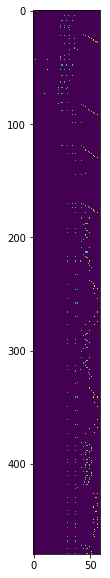

In [125]:
plt.figure(figsize = (200,10))
plt.imshow(Y_0_hat)

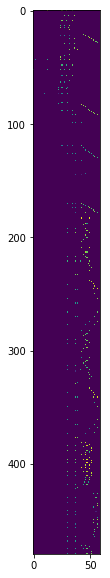

In [126]:
plt.figure(figsize = (200,10))
plt.imshow(Y_test[0].reshape(-1, X_test.shape[-2]))